In [1]:
from scipy.stats import chi2_contingency, beta
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

In [56]:
# control_site = [
#     [99.6, 100.4],
#     [99.7, 108.9],
# ]

control_site = [
    [996, 1004],
    [997, 1089],
]

treatment_site = [
    [888,  844],
    [911, 1088],
]

conv_control_before = control_site[1][0] / (control_site[0][0] + control_site[1][0])
conv_control_after  = control_site[1][1] / (control_site[0][1] + control_site[1][1])
conv_control_lift = conv_control_after / conv_control_before - 1.0
print('conversion at control site before = %.2f' % conv_control_before)
print('conversion at control site after  = %.2f' % conv_control_after)
print('relative conversion lift at control = %.3f (assumed to be seasonality)' % conv_control_lift)
print()

conv_treatment_before = treatment_site[1][0] / (treatment_site[0][0] + treatment_site[1][0])
conv_treatment_after  = treatment_site[1][1] / (treatment_site[0][1] + treatment_site[1][1])
conv_treatment_lift = conv_treatment_after / conv_treatment_before - 1.0
conv_treatment_lift_corr = conv_treatment_lift - conv_control_lift
print('conversion at treatment site before = %.2f' % conv_treatment_before)
print('conversion at treatment site after  = %.2f' % conv_treatment_after)
print('relative conversion lift at treatment = %.3f (including assumed seasonality)' % conv_treatment_lift)
print()

print('relative conversion lift at treatment with correction (seasonality subtracted out) = %.3f' % conv_treatment_lift_corr)

conversion at control site before = 0.50
conversion at control site after  = 0.52
relative conversion lift at control = 0.040 (assumed to be seasonality)

conversion at treatment site before = 0.51
conversion at treatment site after  = 0.56
relative conversion lift at treatment = 0.112 (including assumed seasonality)

relative conversion lift at treatment with correction (seasonality subtracted out) = 0.072


In [21]:
print('p-value of original treatment site contingency matrix = %.3f' % chi2_contingency(treatment_site)[1])

p-value of original treatment site contingency matrix = 0.001


In [25]:
def correct_treatment_contingency_matrix(treatment_site, conv_control_lift):
    conv_treatment_before = treatment_site[1][0] / (treatment_site[0][0] + treatment_site[1][0])
    conv_treatment_after  = treatment_site[1][1] / (treatment_site[0][1] + treatment_site[1][1])
    conv_treatment_lift = conv_treatment_after / conv_treatment_before - 1.0
    conv_treatment_lift_corr = conv_treatment_lift - conv_control_lift
    conv_treatment_after_corr = conv_treatment_before * (1 + conv_treatment_lift_corr)
    treatment_site_corr = deepcopy(treatment_site)
    N = treatment_site_corr[0][1] + treatment_site_corr[1][1]
    treatment_site_corr[0][1] = round((1 - conv_treatment_after_corr) * N)
    treatment_site_corr[1][1] = N - treatment_site_corr[0][1]
    return treatment_site_corr

treatment_site_corr = correct_treatment_contingency_matrix(treatment_site, conv_control_lift)

print('Original treatment site contingency matrix:')
print(np.array(treatment_site))
print('Corrected treatment site contingency matrix:')
print(np.array(treatment_site_corr))

Original treatment site contingency matrix:
[[ 888  844]
 [ 911 1088]]
Corrected treatment site contingency matrix:
[[ 888  883]
 [ 911 1049]]


In [23]:
print('p-value of corrected treatment site contingency matrix = %.3f' % chi2_contingency(treatment_site_corr)[1])

p-value of corrected treatment site contingency matrix = 0.222


In [28]:
def sample_conversion_lifts(site_contingency, num_samples = 10*1000):
    beta_before = beta(site_contingency[1][0], site_contingency[0][0])
    beta_after  = beta(site_contingency[1][1], site_contingency[0][1])
    samples_before = beta_before.rvs(size=num_samples)
    samples_after  = beta_after.rvs(size=num_samples)
    return samples_before, samples_after

def bayesian_prob_after_gt_before(site_contingency, num_samples = 10*1000):
    samples_before, samples_after = sample_conversion_lifts(site_contingency, num_samples)
    hits = sum([after > before for before, after in zip(samples_before, samples_after)])
    return hits/num_samples

print('P(conv_after > conv_before | treatment_site     ): %.4f' % bayesian_prob_after_gt_before(treatment_site))
print('P(conv_after > conv_before | treatment_site_corr): %.4f' % bayesian_prob_after_gt_before(treatment_site_corr))

P(conv_after > conv_before | treatment_site     ): 0.9999
P(conv_after > conv_before | treatment_site_corr): 0.9894


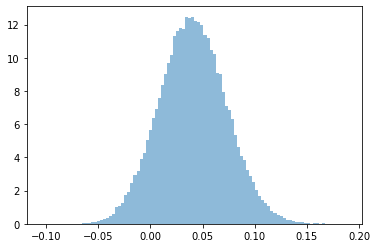

mean relative conversion lift at control = 0.041 (assumed to be seasonality)


In [34]:
num_samples = 100*1000
samples_conv_control_before, samples_conv_control_after = sample_conversion_lifts(control_site, num_samples)
samples_conv_control_lift = [after/before-1 for before, after in zip(samples_conv_control_before, samples_conv_control_after)]
plt.hist(samples_conv_control_lift, bins=100, density=True, alpha=0.5)
plt.show()
print('mean relative conversion lift at control = %.3f (assumed to be seasonality)' % np.mean(samples_conv_control_lift))

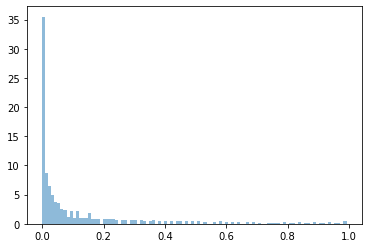

p-value of corrected treatment site contingency matrix (taking into account control site uncertainty) = 0.115


In [30]:
def p_value_corr(treatment_site, conv_control_lift):
    treatment_site_corr = correct_treatment_contingency_matrix(treatment_site, conv_control_lift)
    return chi2_contingency(treatment_site_corr)[1]

num_samples = 100*1000
samples_conv_control_before, samples_conv_control_after = sample_conversion_lifts(control_site, num_samples)
samples_conv_control_lift = [after/before-1 for before, after in zip(samples_conv_control_before, samples_conv_control_after)]
ps = [p_value_corr(treatment_site, lift) for lift in samples_conv_control_lift]
plt.hist(ps, bins=100, density=True, alpha=0.5)
plt.show()
print('p-value of corrected treatment site contingency matrix (taking into account control site uncertainty) = %.3f' % np.mean(ps))

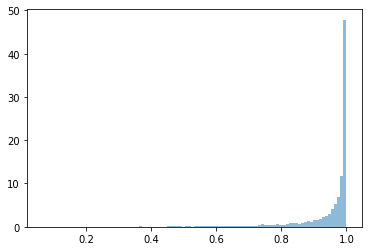

P(conv_after > conv_before | treatment_site_corr) (taking into account control site uncertainty) = 0.942


In [33]:
def bayesian_prob_corr(treatment_site, conv_control_lift):
    treatment_site_corr = correct_treatment_contingency_matrix(treatment_site, conv_control_lift)
    return bayesian_prob_after_gt_before(treatment_site_corr)

num_samples = 10*1000
samples_conv_control_before, samples_conv_control_after = sample_conversion_lifts(control_site, num_samples)
samples_conv_control_lift = [after/before-1 for before, after in zip(samples_conv_control_before, samples_conv_control_after)]
bs = [bayesian_prob_corr(treatment_site, lift) for lift in samples_conv_control_lift]
plt.hist(bs, bins=100, density=True, alpha=0.5)
plt.show()
print('P(conv_after > conv_before | treatment_site_corr) (taking into account control site uncertainty) = %.3f' % np.mean(bs))

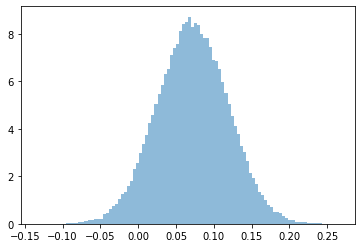

MC mean relative conversion lift at treatment with correction (seasonality subtracted out) = 0.072
P(corrected conversion lift > 0 at treatment site | control_site, treatment_site) = 0.938


In [61]:
def sample_conversion_lifts(site_contingency, num_samples = 100*1000):
    beta_before = beta(site_contingency[1][0], site_contingency[0][0])
    beta_after  = beta(site_contingency[1][1], site_contingency[0][1])
    samples_before = beta_before.rvs(size=num_samples)
    samples_after  = beta_after.rvs(size=num_samples)
    return samples_before, samples_after

samples_control_before, samples_control_after = sample_conversion_lifts(control_site)
samples_treatment_before, samples_treatment_after = sample_conversion_lifts(treatment_site)

def calculate_conv_treatment_lift_corr(conv_control_before, conv_control_after, conv_treatment_before, conv_treatment_after):
    conv_control_lift = conv_control_after / conv_control_before - 1.0
    conv_treatment_lift = conv_treatment_after / conv_treatment_before - 1.0
    conv_treatment_lift_corr = conv_treatment_lift - conv_control_lift
    return conv_treatment_lift_corr

lift_corrs = [calculate_conv_treatment_lift_corr(conv_control_before, conv_control_after, conv_treatment_before, conv_treatment_after)
     for conv_control_before, conv_control_after, conv_treatment_before, conv_treatment_after
         in zip(samples_control_before, samples_control_after, samples_treatment_before, samples_treatment_after)]

plt.hist(lift_corrs, bins=100, density=True, alpha=0.5)
plt.show()

p = sum([lift_corr > 0 for lift_corr in lift_corrs])/len(lift_corrs)

print('MC mean relative conversion lift at treatment with correction (seasonality subtracted out) = %.3f' % np.mean(lift_corrs))
print('P(corrected conversion lift > 0 at treatment site | control_site, treatment_site) = %.3f' % p)